<a href="https://colab.research.google.com/github/Chanuka-ChandraYapa/paddy-yield-prediction/blob/main/CNNLSTMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authenticate and initialize the Earth Engine API


In [ ]:
# Authenticate and initialize the Earth Engine API
import ee
import geemap

ee.Authenticate()
ee.Initialize(project="coherent-span-427904-d1")

Mounted at /content/drive


Mount Google Drive to save the images

In [1]:
# Mount Google Drive to save the images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import mapping

# Load the shapefile from Google Drive or Colab storage
shapefile_path = '/content/drive/MyDrive/Hambantota/hambantota.shp'  # Update this path with your shapefile path
gdf = gpd.read_file(shapefile_path)

aoi = geemap.gdf_to_ee(gdf)

# Function to mask clouds
def mask_clouds(image):
    cloud_prob = image.select('MSK_CLDPRB')
    is_cloud = cloud_prob.lt(5)
    return image.updateMask(is_cloud)

# Function to get monthly images
def get_monthly_images(year, month):
    start_date = f'{year}-{month:02d}-01'
    if month == 12:
        end_date = f'{year + 1}-01-01'
    else:
        end_date = f'{year}-{month + 1:02d}-01'

    # Filter the image collection for the month and apply the cloud mask
    monthly_collection = sentinel2.filterDate(start_date, end_date).mean()
    return monthly_collection.clip(aoi)

# Sentinel-2 ImageCollection
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate('2022-01-01', '2023-12-31') \
    .filterBounds(aoi) \
    .map(mask_clouds) \
    .select(['B2', 'B3', 'B4', 'B8'])  # Example bands: Blue, Green, Red, NIR

# Loop through the months and retrieve all available images
monthly_images = []
for year in range(2022, 2024):
    for month in range(1, 13):
        monthly_image = get_monthly_images(year, month)
        monthly_images.append(monthly_image)

# Stack all monthly images into a single ImageCollection
monthly_series = ee.ImageCollection.fromImages(monthly_images)
print(f"Total number of monthly images: {monthly_series.size().getInfo()}")

# Example of visualizing the first image
import matplotlib.pyplot as plt
import geemap

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(monthly_series.first(), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'First Monthly Image')
Map.addLayer(aoi, {}, 'Shapefile Area')
Map.addLayerControl()
Map

Total number of monthly images: 24
Export task for the first image started.


In [ ]:
import time

# Function to export image to Google Drive
def export_to_drive(image, file_name, aoi):
    task = ee.batch.Export.image.toDrive(**{
        'image': image.clip(aoi),  # Clip the image to the area of interest
        'description': file_name,
        'folder': 'GEE_Images',
        'scale': 10,  # Adjust scale as needed
        'region': aoi.geometry().bounds().getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'maxPixels': 1e13
    })
    task.start()
    return task

# Export all monthly images with task monitoring
tasks = []
for i, image in enumerate(monthly_images):
    year = 2022 + (i // 12)
    month = (i % 12) + 1
    file_name = f'Badulla_ROI_Sentinel2_{year}_{month:02d}'
    task = export_to_drive(image, file_name, aoi)
    tasks.append(task)
    print(f"Started export task for {year}-{month:02d}")

# Monitor the tasks
for task in tasks:
    while task.active():
        print(f"Task {task.id} is running...")
        time.sleep(10)  # Wait for 10 seconds before checking again

    # Check if the task is completed
    if task.status()['state'] == 'COMPLETED':
        print(f"Task {task.id} completed successfully!")
    else:
        print(f"Task {task.id} failed with error: {task.status()['error_message']}")


Started export task for 2022-01
Started export task for 2022-02
Started export task for 2022-03
Started export task for 2022-04
Started export task for 2022-05
Started export task for 2022-06
Started export task for 2022-07
Started export task for 2022-08
Started export task for 2022-09
Started export task for 2022-10
Started export task for 2022-11
Started export task for 2022-12
Started export task for 2023-01
Started export task for 2023-02
Started export task for 2023-03
Started export task for 2023-04
Started export task for 2023-05
Started export task for 2023-06
Started export task for 2023-07
Started export task for 2023-08
Started export task for 2023-09
Started export task for 2023-10
Started export task for 2023-11
Started export task for 2023-12
Task 2YRQARCPEZZZFDPKCPP2I4N2 is running...
Task 2YRQARCPEZZZFDPKCPP2I4N2 is running...
Task 2YRQARCPEZZZFDPKCPP2I4N2 is running...
Task 2YRQARCPEZZZFDPKCPP2I4N2 is running...
Task 2YRQARCPEZZZFDPKCPP2I4N2 is running...
Task 2YRQARC

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 64.3 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
import rasterio
import numpy as np
import tensorflow as tf

import gc

def downscale_image(image, scale_factor):
    # Get the original shape
    print(image.shape)
    if image.ndim == 3:  # Check if the image has a band dimension
        bands, height, width = image.shape
        # Calculate new dimensions
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        # Resize the image, handling the band dimension
        return np.array([tf.image.resize(image[b, :, :][None, :, :, None],
                                        (new_height, new_width)).numpy()[0, :, :, 0] for b in range(bands)])
    else:  # Handle the case where the image already has the expected shape
        height, width, channels = image.shape
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        return tf.image.resize(image, (new_height, new_width)).numpy()

def process_and_save_one_by_one(image_folder, output_folder, scale_factor=0.5):
    for i, filename in enumerate(os.listdir(image_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(image_folder, filename)
            with rasterio.open(filepath) as src:
                image = src.read()  # Read all bands
                if scale_factor < 1.0:
                    image = downscale_image(image, scale_factor)
                # Save the image individually
                output_path = os.path.join(output_folder, f'image_{filename}.npy')
                np.save(output_path, image)
                print(f"Saved {output_path}")
            # Free memory
            del image
            gc.collect()

# Example usage
image_folder = '/content/drive/MyDrive/GEE_Images'
output_folder = '/content/drive/MyDrive/GEE_Images/Processed_Images'
os.makedirs(output_folder, exist_ok=True)

process_and_save_one_by_one(image_folder, output_folder, scale_factor=0.5)



(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_01-0000000000-0000000000.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_01-0000000000-0000011776.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000000000.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000011776.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000000000.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000011776.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2022_05-0000000000-0000000000.tif.npy
(4, 6777, 460)
Saved /cont

In [ ]:
import os
import rasterio
import numpy as np
import tensorflow as tf

import gc

def downscale_image(image, scale_factor):
    # Get the original shape
    print(image.shape)
    if image.ndim == 3:  # Check if the image has a band dimension
        bands, height, width = image.shape
        # Calculate new dimensions
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        # Resize the image, handling the band dimension
        return np.array([tf.image.resize(image[b, :, :][None, :, :, None],
                                        (new_height, new_width)).numpy()[0, :, :, 0] for b in range(bands)])
    else:  # Handle the case where the image already has the expected shape
        height, width, channels = image.shape
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        return tf.image.resize(image, (new_height, new_width)).numpy()

def process_and_save_one_by_one(image_folder, output_folder, scale_factor=0.5):
    for i, filename in enumerate(os.listdir(image_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(image_folder, filename)
            with rasterio.open(filepath) as src:
                image = src.read()  # Read all bands
                if scale_factor < 1.0:
                    image = downscale_image(image, scale_factor)
                # Save the image individually
                output_path = os.path.join(output_folder, f'image_{filename}.npy')
                np.save(output_path, image)
                print(f"Saved {output_path}")
            # Free memory
            del image
            gc.collect()

# Example usage
image_folder = '/content/drive/MyDrive/GEE_Images_old'
output_folder = '/content/drive/MyDrive/GEE_Images/Processed_Images'
os.makedirs(output_folder, exist_ok=True)

process_and_save_one_by_one(image_folder, output_folder, scale_factor=0.5)

(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2018_06-0000000000-0000011776.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2018_12-0000000000-0000000000.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2021_05-0000000000-0000000000.tif.npy
(4, 6777, 11776)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2020_11-0000000000-0000000000.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2021_05-0000000000-0000011776.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2019_07-0000000000-0000011776.tif.npy
(4, 6777, 460)
Saved /content/drive/MyDrive/GEE_Images/Processed_Images/image_Badulla_ROI_Sentinel2_2018_02-0000000000-0000011776.tif.npy
(4, 6777, 11776)
Saved /cont

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def process_and_save_images(input_dir, output_dir, target_shape=(128, 128, 4)):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    for filename in os.listdir(input_dir):
        if filename.endswith('.npy'):
            filepath = os.path.join(input_dir, filename)

            # Load the image
            image = np.load(filepath)
            print(f"Loaded image: {filename}")

            # Swap axes to (H, W, B)
            image = np.moveaxis(image, 0, -1)  # assuming original shape is (B, H, W)

            # Normalize the image (e.g., to range [0, 1])
            H, W, B = image.shape
            image = image.reshape(-1, B)
            image = scaler.fit_transform(image)
            image = image.reshape(H, W, B)

            # Resize image to target shape
            resized_image = tf.image.resize(image, target_shape[:2]).numpy()

            # Save the processed image to the output directory
            output_filepath = os.path.join(output_dir, filename)
            np.save(output_filepath, resized_image)
            print(f"Saved processed image: {output_filepath}")

# Example usage
input_folder = '/content/drive/MyDrive/GEE_Images/Processed_Images'  # Update with your path
output_folder = '/content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images'  # Update with your desired output path
process_and_save_images(input_folder, output_folder, target_shape=(128, 128, 4))


Loaded image: image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000011776.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2022_02-0000000000-0000011776.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000011776.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2022_03-0000000000-0000011776.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2022_05-0000000000-0000000000.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Loaded image: image_Badulla_ROI_Sentinel2_2019_03-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2019_03-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2020_10-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2020_10-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2019_05-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2019_05-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2019_06-0000000000-0000000000.tif.npy
Saved processed image: /content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images/image_Badulla_ROI_Sentinel2_2019_06-0000000000-0000000000.tif.npy
Loaded image: image_Badulla_ROI_Sentinel2_2020_09-0000000000-0000011776.

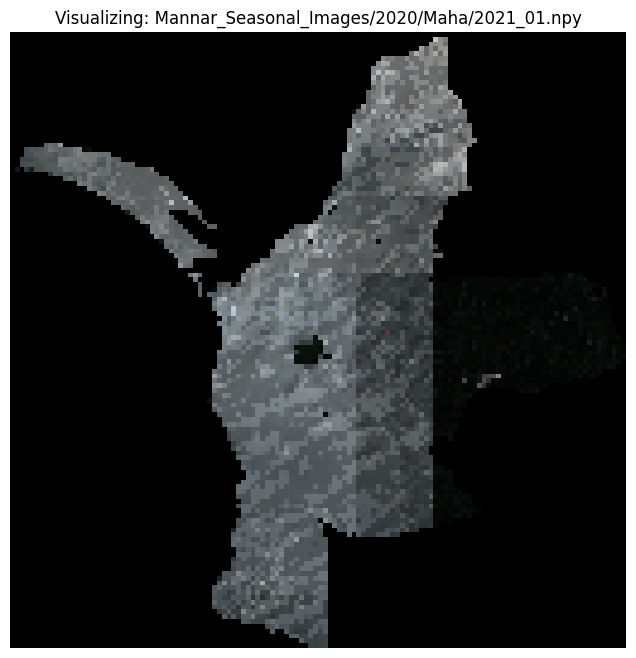

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Load one image from the output directory
output_folder = '/content/drive/MyDrive/GEE_Images'  # Update with your output path
filename = 'Mannar_Seasonal_Images/2020/Maha/2021_01.npy'  # Replace with the actual filename you want to visualize
filepath = os.path.join(output_folder, filename)

# Load the image
image = np.load(filepath)
image = np.nan_to_num(image, nan=0.0)

# Visualize the image
plt.figure(figsize=(8, 8))
plt.imshow(image[:, :, :3])  # Display the first three bands as RGB
plt.title(f'Visualizing: {filename}')
plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths and constants
input_folder = '/content/drive/MyDrive/GEE_Images/Processed_and_Resized_Images'  # Update with your folder path
output_base_folder = '/content/drive/MyDrive/GEE_Images/Seasonal_Images'  # Output folder path
yala_months = {"03","04", "05", "06", "07", "08"}
maha_months_current = {"09", "10", "11", "12"}
maha_months_next = {"01", "02"}
image_files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

# Function to get the month and year from filename
def extract_date(filename):
    parts = filename.split('_')
    year = parts[4]  # '2022_09' from the filename
    month = parts[5][:2]
    return year, month

# Helper function to concatenate images
def concatenate_images(img1, img2):
    return np.concatenate((img1, img2), axis=1)  # Change axis as needed

# Process images
for file in image_files:
    year, month = extract_date(file)
    img_path = os.path.join(input_folder, file)
    img = np.load(img_path)  # Load the image

    # Determine the correct season folder
    if month in yala_months:
        season = 'Yala'
        year_folder = os.path.join(output_base_folder, year)
        if not os.path.exists(year_folder):
            os.makedirs(year_folder)
        season_folder = os.path.join(year_folder, season)
        if not os.path.exists(season_folder):
            os.makedirs(season_folder)

        # Save the images
        img_filename = f"{year}_{month}.npy"
        img_save_path = os.path.join(season_folder, img_filename)

        if os.path.exists(img_save_path):
            existing_img = np.load(img_save_path)
            concatenated_img = concatenate_images(existing_img, img)
            np.save(img_save_path, concatenated_img)
        else:
            np.save(img_save_path, img)

    elif month in maha_months_current:
        season = 'Maha'
        year_folder = os.path.join(output_base_folder, year)
        if not os.path.exists(year_folder):
            os.makedirs(year_folder)
        season_folder = os.path.join(year_folder, season)
        if not os.path.exists(season_folder):
            os.makedirs(season_folder)

        # Save the images
        img_filename = f"{year}_{month}.npy"
        img_save_path = os.path.join(season_folder, img_filename)

        if os.path.exists(img_save_path):
            # existing_img = np.load(img_save_path)
            # concatenated_img = concatenate_images(existing_img, img)
            # np.save(img_save_path, concatenated_img)
            continue
        else:
            np.save(img_save_path, img)

    elif month in maha_months_next:
        # For months January to March, save in the previous year's Maha folder
        prev_year = str(int(year) - 1)
        season = 'Maha'
        year_folder = os.path.join(output_base_folder, prev_year)
        if not os.path.exists(year_folder):
            os.makedirs(year_folder)
        season_folder = os.path.join(year_folder, season)
        if not os.path.exists(season_folder):
            os.makedirs(season_folder)

        # Save the images
        img_filename = f"{year}_{month}.npy"
        img_save_path = os.path.join(season_folder, img_filename)

        if os.path.exists(img_save_path):
            # existing_img = np.load(img_save_path)
            # concatenated_img = concatenate_images(existing_img, img)
            # np.save(img_save_path, concatenated_img)
            continue
        else:
            np.save(img_save_path, img)

print("Processing completed.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing completed.


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/Weather Data/weatherData.csv")
df = df[df['location_id'] == 8]

# Convert the 'date' column to datetime objects for proper comparison
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Filter the dataframe based on the date range
start_date = pd.to_datetime('1/1/2019', format='%m/%d/%Y')
end_date = pd.to_datetime('12/31/2023', format='%m/%d/%Y')
df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

df = df_filtered
df


,location_id,date,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),daylight_duration (s),...,precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm),sunrise,sunset
45471,8,2019-01-01,2,30.0,23.5,26.3,31.6,24.9,27.5,42377.69,...,0.0,0.0,0,27.5,57.2,41,19.77,5.09,06:15,18:01
45472,8,2019-01-02,3,30.6,23.9,26.5,34.2,24.2,27.5,42382.60,...,0.0,0.0,0,23.7,49.7,42,21.52,5.72,06:16,18:02
45473,8,2019-01-03,1,30.6,24.1,26.7,34.0,24.2,27.9,42387.98,...,0.0,0.0,0,23.2,47.5,44,22.73,6.00,06:16,18:02
45474,8,2019-01-04,1,30.6,23.7,26.5,32.7,24.0,27.1,42393.81,...,0.0,0.0,0,25.5,52.9,39,23.02,6.14,06:16,18:03
45475,8,2019-01-05,51,30.6,23.1,26.5,33.1,24.3,28.1,42400.10,...,0.5,0.5,3,23.3,50.0,38,18.57,4.90,06:17,18:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47292,8,2023-12-27,55,29.4,24.6,26.7,32.7,27.2,29.3,42359.49,...,4.9,4.9,11,28.8,56.2,43,19.20,4.19,06:13,17:59
47293,8,2023-12-28,63,26.5,23.5,25.0,29.6,26.4,28.0,42362.14,...,17.5,17.5,24,27.4,51.1,50,7.64,1.65,06:13,17:59
47294,8,2023-12-29,63,27.6,23.9,25.0,31.6,26.7,28.3,42365.25,...,11.0,11.0,15,18.9,40.0,45,8.97,1.95,06:14,18:00
47295,8,2023-12-30,53,29.2,24.4,26.1,33.3,27.2,29.0,42368.81,...,1.8,1.8,8,25.7,49.7,47,16.28,3.49,06:14,18:00


In [ ]:
numeric_cols = ['sunrise', 'sunset']  # Add other numeric columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
monthly_mean = df.groupby(['year', 'month']).mean().reset_index()
monthly_mean


,year,month,location_id,date,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),...,precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm),sunrise,sunset
0,2019,1,8.0,2019-01-16 00:00:00,34.064516,31.225806,23.596774,26.822581,34.203226,25.409677,...,0.651613,0.651613,2.741935,21.680645,46.300000,43.806452,20.420323,5.179032,NaN,NaN
1,2019,2,8.0,2019-02-14 12:00:00,47.964286,30.935714,24.478571,27.225000,34.714286,27.675000,...,6.900000,6.900000,5.892857,21.135714,46.217857,74.428571,20.635357,4.869643,NaN,NaN
2,2019,3,8.0,2019-03-16 00:00:00,36.419355,31.483871,24.661290,27.800000,35.741935,28.625806,...,1.454839,1.454839,4.483871,21.003226,46.506452,109.806452,22.569032,5.208065,NaN,NaN
3,2019,4,8.0,2019-04-15 12:00:00,46.933333,31.693333,25.486667,28.236667,37.086667,30.513333,...,2.316667,2.316667,6.833333,16.270000,39.116667,204.700000,20.234333,4.480667,NaN,NaN
4,2019,5,8.0,2019-05-16 00:00:00,46.193548,31.503226,26.170968,28.506452,34.993548,29.922581,...,1.722581,1.722581,6.419355,26.348387,57.454839,240.387097,20.327097,4.931935,NaN,NaN
5,2019,6,8.0,2019-06-15 12:00:00,46.333333,31.843333,26.233333,28.653333,34.340000,29.396667,...,1.880000,1.880000,6.766667,29.203333,64.466667,247.500000,19.045000,4.993667,NaN,NaN
6,2019,7,8.0,2019-07-16 00:00:00,47.483871,31.567742,25.880645,28.283871,33.941935,28.993548,...,1.348387,1.348387,6.064516,28.938710,63.032258,242.709677,19.730323,5.094194,NaN,NaN
7,2019,8,8.0,2019-08-16 00:00:00,53.193548,30.119355,25.287097,27.319355,32.783871,28.074194,...,3.477419,3.477419,11.677419,27.319355,60.632258,243.870968,17.110645,4.154194,NaN,NaN
8,2019,9,8.0,2019-09-15 12:00:00,51.833333,29.316667,24.973333,26.803333,33.203333,28.430000,...,5.036667,5.036667,13.000000,22.796667,50.803333,219.600000,17.801667,3.919000,NaN,NaN
9,2019,10,8.0,2019-10-16 00:00:00,59.000000,28.606452,24.206452,26.141935,34.038710,28.545161,...,10.077419,10.077419,14.645161,15.370968,35.690323,190.225806,15.846774,3.260323,NaN,NaN


In [ ]:
monthly_mean.to_csv('/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/Weather Data/monthly_weather_data.csv', index=False)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model for processing satellite images
def create_cnn_model(input_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    return cnn_model

# Define the ground data feature extraction model
def create_ground_data_model(input_shape):
    ground_model = models.Sequential()
    ground_model.add(layers.Dense(128, activation='relu', input_shape=input_shape))
    ground_model.add(layers.Dense(64, activation='relu'))
    return ground_model

# Define the Stacked LSTM model
def create_stacked_lstm_model(cnn_input_shape, ground_input_shape, T):
    # CNN for satellite images
    cnn_model = create_cnn_model(cnn_input_shape)

    # Ground data feature extraction
    ground_model = create_ground_data_model(ground_input_shape)

    # Define the input layers
    satellite_input = layers.Input(shape=(T,) + cnn_input_shape)
    ground_input = layers.Input(shape=(T,) + ground_input_shape)

    # Process each time step individually
    cnn_features = layers.TimeDistributed(cnn_model)(satellite_input)
    ground_features = layers.TimeDistributed(ground_model)(ground_input)

    # Mid-level fusion
    fused_features = layers.Concatenate()([cnn_features, ground_features])

    # First LSTM layer for intra-seasonal dependencies
    lstm_1 = layers.LSTM(256, return_sequences=True)(fused_features)

    # Second LSTM layer for inter-seasonal dependencies
    lstm_2 = layers.LSTM(128)(lstm_1)

    # Output layer for crop yield prediction
    output = layers.Dense(1, activation='linear')(lstm_2)

    # Define the full model
    model = models.Model(inputs=[satellite_input, ground_input], outputs=output)

    return model

# Define the input shapes based on your data
cnn_input_shape = (128, 128, 4)  # Example: 128x128 RGB images
ground_input_shape = (4,)       # Example: 64 ground data features
T = 6                            # Number of time steps in one growing season

# Create the model
model = create_stacked_lstm_model(cnn_input_shape, ground_input_shape, T)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 6, 128, 128, 4) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 6, 4)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 6, 57600)       │         19,680 │ input_layer_2[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 6, 64)          │          8,896 │ input_layer_3[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6, 57664)       │              0 │ time_distributed[0][0… │
│                           │                        │                │ time_distributed_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 6, 256)         │     59,311,104 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │        197,120 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 59,536,929 (227.12 MB)

 Trainable params: 59,536,929 (227.12 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths
base_path = "/content/drive/MyDrive/GEE_Images/Seasonal_Images"
years = ["2019", "2020", "2021", "2022", "2023"]
seasons = ["Yala", "Maha"]

cnn_input_shape = (128, 128, 4)  # Adjust this based on your CNN model's input shape

# Function to load and preprocess images
def load_images_from_folder(folder_path, input_shape, expected_count):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.npy'):
            img_path = os.path.join(folder_path, filename)
            img = np.load(img_path)
            img = np.nan_to_num(img, nan=0.0)
            if img.shape != input_shape:
                print(f"Warning: Image {filename} has shape {img.shape}, expected {input_shape}")
                img = np.resize(img, input_shape)
            images.append(img)
    # Handle cases with missing images by padding or discarding
    if len(images) < expected_count:
        # Pad with zeros if fewer images than expected
        while len(images) < expected_count:
            padding_image = np.zeros(input_shape)
            images.append(padding_image)
    elif len(images) > expected_count:
        # Trim the excess images if more than expected
        images = images[:expected_count]

    return np.array(images)

# Function to prepare data for the model
def prepare_data_for_model(base_path, years, seasons, input_shape):
    all_season_data = []
    for year in years:
        for season in seasons:
            folder_path = os.path.join(base_path, year, season)
            expected_count = 6 if season == "Maha" else 6  # Adjust expected count based on season
            images = load_images_from_folder(folder_path, input_shape, expected_count)
            all_season_data.append(images)
    return all_season_data  # Return as a list of arrays instead of a single array

# Prepare the satellite data
satellite_input = prepare_data_for_model(base_path, years, seasons, cnn_input_shape)
satellite_input_2 = prepare_data_for_model("/content/drive/MyDrive/GEE_Images/Polonnaruwa_Seasonal_Images", years, seasons, cnn_input_shape)
satellite_input.extend(satellite_input_2)
satellite_input_3 = prepare_data_for_model("/content/drive/MyDrive/GEE_Images/Mannar_Seasonal_Images", years, seasons, cnn_input_shape)
satellite_input.extend(satellite_input_3)


In [18]:
len(satellite_input)

30

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the ground data
ground_data_path = "/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/Weather Data/monthly_weather_data.csv"
ground_df = pd.read_csv(ground_data_path)
ground_data_path = "/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/Weather Data/monthly_weather_data_polonnaruwa.csv"
ground_df1 = pd.read_csv(ground_data_path)
ground_data_path = "/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/Weather Data/monthly_weather_data_mannar.csv"
ground_df2 = pd.read_csv(ground_data_path)

# Extract relevant columns (you can adjust this as per your needs)
features = ['temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'precipitation_sum (mm)', 'wind_speed_10m_max (km/h)']  # Example features

# Normalize the data
scaler = MinMaxScaler()
ground_df[features] = scaler.fit_transform(ground_df[features])

# Prepare the ground data for each year and season
def prepare_ground_data(df, years, seasons):
    ground_data = []
    for year in years:
        for season in seasons:
            season_df = df[(df['year'] == int(year)) & (df['month'].isin(season_months[season]))]
            ground_data.append(season_df[features].values)
    return ground_data

# Define the months for each season
season_months = {
    "Yala": [3,4, 5, 6, 7, 8],  # Adjust these months as per your season definitions
    "Maha": [9, 10, 11, 12, 1, 2]
}

# Prepare the ground data
ground_input = prepare_ground_data(ground_df, years, seasons)
ground_input1 = prepare_ground_data(ground_df1, years, seasons)
ground_input2 = prepare_ground_data(ground_df2, years, seasons)
ground_input.extend(ground_input1)
ground_input.extend(ground_input2)


# Now `ground_input` can be used as the ground data input to your model

# Check the shapes
for i, season_data in enumerate(satellite_input):
    print(f"Season {i+1}: Satellite input shape = {season_data.shape}, Ground input shape = {ground_input[i].shape}")


Season 1: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 2: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 3: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 4: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 5: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 6: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 7: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 8: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 9: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 10: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 11: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 12: Satellite input shape = (6, 128, 128, 4), Ground input shape = (6, 4)
Season 13: Satellite input shape = (6

In [9]:
yield_df = pd.read_csv("/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/filtered_combined.csv")

# Drop unnecessary columns and filter for Hambantota district
filtered_df = yield_df[['Year','District', 'Yield']].copy()
hambantota_yield_df = filtered_df[filtered_df['District'] == 'HAMBANTOTA']
hambantota_yield_df = hambantota_yield_df.iloc[28:]

# Display the filtered DataFrame
hambantota_yield_df.to_csv('/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/filtered_hambantota_yield.csv', index=False)
hambantota_yield_df

,Year,District,Yield
277,2019,HAMBANTOTA,6.621978611
287,2019,HAMBANTOTA,5.726118952
297,2020,HAMBANTOTA,6.302316438
307,2020,HAMBANTOTA,5.985626215
317,2021,HAMBANTOTA,5.883147984
327,2021,HAMBANTOTA,5.813698812
337,2022,HAMBANTOTA,3.969293366
347,2022,HAMBANTOTA,4.612436707
357,2023,HAMBANTOTA,5.467847386
367,2023,HAMBANTOTA,5.086920242


In [20]:
# Model input
model_input = [satellite_input, ground_input]

In [21]:
import pandas as pd
import numpy as np

# Load yield data
yield_data = pd.read_csv('/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/filtered_hambantota_yield.csv')
yield_data1 = pd.read_csv('/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/filtered_polonnaruwa_yield.csv')
yield_data2 = pd.read_csv('/content/drive/MyDrive/FYP20-Satellite Image Analysis/Data sets/filtered_mannar_yield.csv')


def create_y_target(yield_data):
    # Ensure the data is sorted by Year and District (if needed)
    yield_data = yield_data.sort_values(by=['Year', 'District'])

    # Extract yield values and map to seasons
    years = ["2019", "2020", "2021", "2022", "2023"]
    seasons = ["Yala", "Maha"]

    Y_target = []

    for year in years:
        # Filter data for the current year
        year_data = yield_data[yield_data['Year'] == int(year)]

        # Extract Yala and Maha yields
        yala_yield = year_data.iloc[0]['Yield']
        maha_yield = year_data.iloc[1]['Yield']

        # Append to Y_target
        Y_target.append(yala_yield)
        Y_target.append(maha_yield)

    # Convert Y_target to numpy array
    Y_target = np.array(Y_target)
    return Y_target

Y_target1 = create_y_target(yield_data)
Y_target2 = create_y_target(yield_data1)
Y_target3 = create_y_target(yield_data2)

Y_target = np.concatenate((Y_target1, Y_target2))
Y_target = np.concatenate((Y_target, Y_target3))
print(Y_target)


[6.62197861 5.72611895 6.30231644 5.98562621 5.88314798 5.81369881
 3.96929337 4.61243671 5.46784739 5.08692024 5.07482746 5.51100478
 5.4041318  5.24445657 5.22023587 5.44062392 3.10285772 4.28832546
 4.41633298 4.91828694 5.11225266 5.51546392 4.82711443 5.37345478
 5.22829365 4.9309816  2.66244353 3.42468908 3.49732392 4.82670203]


In [11]:
from tensorflow.keras.optimizers import Adam

X_satellite = np.array(satellite_input)  # Shape: (10, T, 128, 128, 4)
X_ground = np.array(ground_input)        # Shape: (10, T, 4)

T = None  # Let T be variable because the input sequence length varies

model = create_stacked_lstm_model(cnn_input_shape, ground_input_shape, T)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit the model
model.fit([X_satellite, X_ground], Y_target, epochs=50, batch_size=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 2.7946
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.4596
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - loss: 0.8779
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 1.2409
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.8161
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.0988
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.6361
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.6917
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.6900
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.6556
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 0.5344
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.4996
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.6867
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.2836
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.4285
Epoch 16/50
20/20 ━

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

X_satellite = np.array(satellite_input)  # Shape: (10, T, 128, 128, 4)
X_ground = np.array(ground_input)        # Shape: (10, T, 4)

T = None  # Let T be variable because the input sequence length varies

model = create_stacked_lstm_model(cnn_input_shape, ground_input_shape, T)

# Split satellite data
X_satellite_train, X_satellite_test, X_ground_train, X_ground_test, Y_train, Y_test = train_test_split(
    X_satellite, X_ground, Y_target, test_size=0.2, random_state=42
)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit([X_satellite_train, X_ground_train], Y_train, epochs=50, batch_size=1, validation_data=([X_satellite_test, X_ground_test], Y_test))


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - loss: 0.6449 - val_loss: 0.4981
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 1.2689 - val_loss: 0.5495
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.6408 - val_loss: 0.4917
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.5684 - val_loss: 0.4650
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.8243 - val_loss: 0.4854
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.6447 - val_loss: 0.4547
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.5560 - val_loss: 0.4582
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 0.7118 - val_loss: 0.4397
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.5825 - val_loss: 0.4396
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.9468 - val_loss: 0.5219
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 1.1596 - val_loss: 0.5714
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.6917 - val_lo

In [28]:
model.save('/content/drive/MyDrive/GEE_Images/crop_yield_prediction_model_new.h5')

In [29]:
loss = model.evaluate([X_satellite_test, X_ground_test], Y_test)
print(f"Test Loss: {loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7093
Test Loss: 0.7093431353569031


In [32]:
predictions = model.predict([X_satellite_test, X_ground_test])
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
[[4.0804615]
 [4.590629 ]
 [4.437063 ]
 [4.1650496]
 [4.1243763]
 [4.449276 ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
   Actual Yield  Predicted Yield
0      3.424689         4.080462
1      5.440624         4.590629
2      5.373455         4.437063
3      4.288325         4.165050
4      5.467847         4.124376
5      5.086920         4.449276


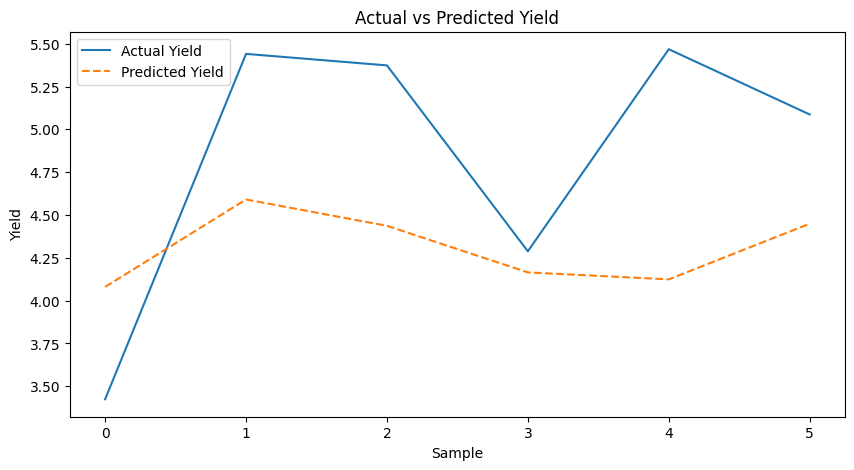

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict([X_satellite_test, X_ground_test])

# Create a DataFrame to compare actual and predicted yields
comparison_df = pd.DataFrame({
    'Actual Yield': Y_test.flatten(),
    'Predicted Yield': predictions.flatten()
})

# Print the DataFrame
print(comparison_df)

# Plot actual vs. predicted yields
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='Actual Yield')
plt.plot(predictions, label='Predicted Yield', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/content/drive/MyDrive/GEE_Images/tmp/checkpoint'  # You can change this path to where you want to save the model

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Saves only the model weights instead of the entire model
    save_best_only=False,    # Saves the model at every epoch, not just when performance improves
    monitor='val_loss',      # Monitors validation loss; change to 'loss' if you want to monitor training loss
    verbose=1
)

model.fit(
    [X_satellite_train, X_ground_train],
    Y_train,
    epochs=50,
    batch_size=1,
    validation_data=([X_satellite_test, X_ground_test], Y_test),
    callbacks=[checkpoint_callback]  # Add the callback here
)

# Load the model weights from the last checkpoint
model.load_weights(checkpoint_filepath)

# Resume training
model.fit(
    [X_satellite_train, X_ground_train],
    Y_train,
    epochs=50,  # Continue training for more epochs
    batch_size=1,
    validation_data=([X_satellite_test, X_ground_test], Y_test),
    callbacks=[checkpoint_callback]  # Keep saving checkpoints
)

